In [34]:
import numpy as np
import os
import sys
import torch
import matplotlib.pyplot as plt

sys.path.append(os.path.dirname((os.path.abspath(os.getcwd()))))

from utils import fft_denoise, wavelet_denoise, compute_metrics
from datasets import ECGDataset
from models import *

model_dict = {
    "U-Net": UNet,
    "ACDAE": ACDAE,
    "DACNN": Seq2Seq2,
    "RALENet": ralenet,
    "AGS-UNet": AGSUNet,
}


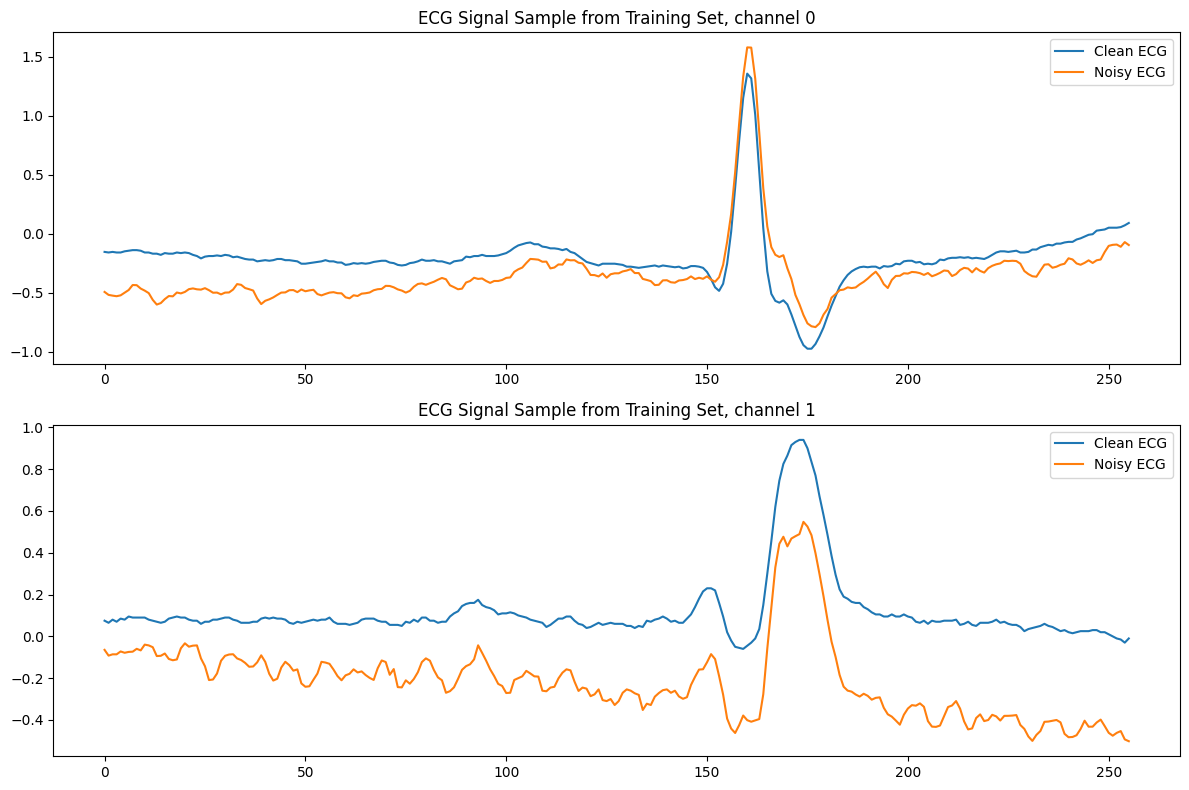

In [47]:
noise_type = "emb"
snr_db = -4

dataset = ECGDataset(
	split="test",
	noise_type=noise_type,
	snr_db=snr_db,
	split_dir="./data_split",
)
idx = np.random.randint(0, len(dataset) - 1)
noisy, clean = dataset[idx]

mean, std = dataset.get_stats()
ori_mean = mean.squeeze(0).permute(1, 0)
ori_std = std.squeeze(0).permute(1, 0)

ori_noisy = noisy * ori_std + ori_mean


plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(clean[0].numpy(), label="Clean ECG")
plt.plot(ori_noisy[0].numpy(), label="Noisy ECG")
plt.legend()
plt.title("ECG Signal Sample from Training Set, channel 0")

plt.subplot(2, 1, 2)
plt.plot(clean[1].numpy(), label="Clean ECG")
plt.plot(ori_noisy[1].numpy(), label="Noisy ECG")
plt.legend()
plt.title("ECG Signal Sample from Training Set, channel 1")

plt.tight_layout()
plt.show()

U-Net Denoising Metrics: {'RMSE': 0.15788738429546356, 'SNR': 4.864310264587402}
ACDAE Denoising Metrics: {'RMSE': 0.11696739494800568, 'SNR': 7.469962120056152}
DACNN Denoising Metrics: {'RMSE': 0.13073602318763733, 'SNR': 6.503352642059326}
RALENet Denoising Metrics: {'RMSE': 0.17673084139823914, 'SNR': 3.8850114345550537}
AGS-UNet Denoising Metrics: {'RMSE': 0.11141803115606308, 'SNR': 7.892148494720459}


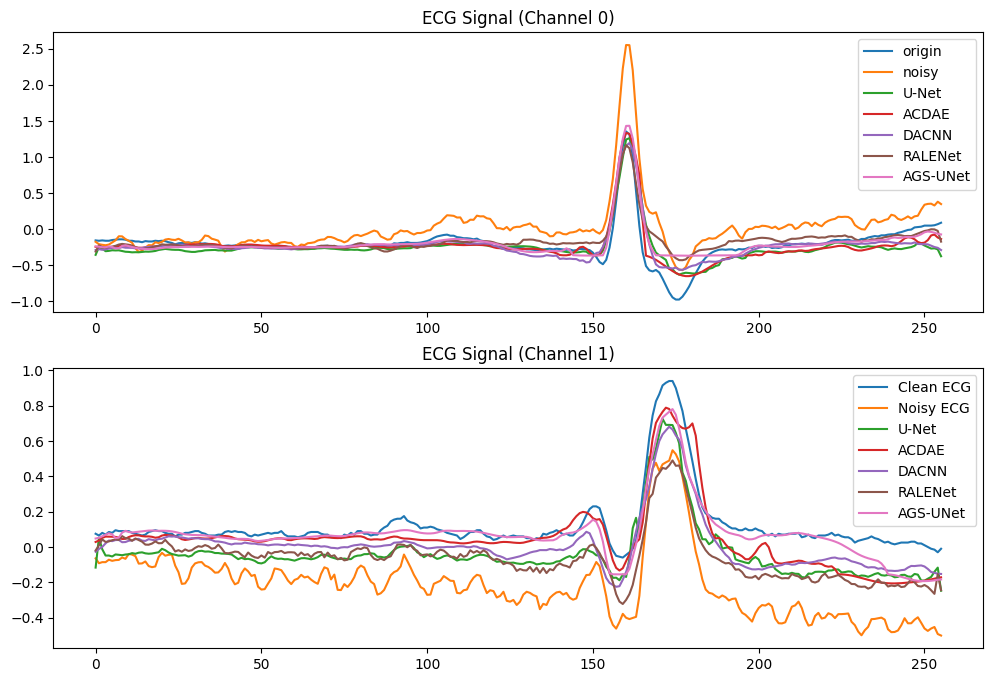

In [48]:
model_name = "AGSUNet"  # Options: "UNet", "ACDAE", "Seq2Seq2", "ralenet", "AGSUNet"

denoised_output_dict = {}
for model_name in model_dict.keys():
	model = model_dict[model_name]()
	model.load_state_dict(torch.load(f"./checkpoints/best_{model_name}_{noise_type}_snr_{snr_db}.pth", map_location="cpu"))
	model.eval()

	with torch.no_grad():
		noisy_input = torch.tensor(noisy)
		noisy_input = noisy_input.unsqueeze(0)  # Add batch dimension
		denoised_output = model(noisy_input)

	clean_metric = torch.tensor(clean).unsqueeze(0)  # Add batch dimension
	metrics_res = compute_metrics(denoised_output, clean_metric, mean, std)
	print(f"{model_name} Denoising Metrics:", metrics_res)

	denoised_output = denoised_output.squeeze(0)  # Remove batch dimension

	_mean = np.array(mean).squeeze()
	_std = np.array(std).squeeze()

	for i in range(denoised_output.shape[0]):
		denoised_output[i] = denoised_output[i] * _std[i] + _mean[i]
	
	denoised_output_dict[model_name] = denoised_output


_mean = np.array(mean).squeeze()
_std = np.array(std).squeeze()
noisy[i] = noisy[i] * _std[i] + _mean[i]

plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(clean[0], label="origin")
plt.plot(noisy[0], label="noisy")
for model_name, denoised_output in denoised_output_dict.items():
	plt.plot(denoised_output[0], label=f"{model_name}")
plt.title("ECG Signal (Channel 0)")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(clean[1], label="Clean ECG")
plt.plot(noisy[1], label="Noisy ECG")
for model_name, denoised_output in denoised_output_dict.items():
	plt.plot(denoised_output[1], label=f"{model_name}")
plt.title("ECG Signal (Channel 1)")
plt.legend()

plt.show()